# SK하이닉스 주가 예측 
* (딥러닝) LSTM 을 이용해 sk하이닉스의 과거의 주가 데이터로 주가 예측을 해보자

  * LSTM 이전 데이터를 가지고 이후의 데이터를 예측하는 딥러닝 모델



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

# Load Dataset

* 2018년 1월 3일 - 2023년 1월 3일 sk하이닉스의 5년 데이터

In [ ]:
data = pd.read_csv('shi.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-03,78100,78800,77300,77700,72623.21094,3097644
1,2018-01-04,78700,79700,77100,77100,72062.42969,3729328
2,2018-01-05,78400,79400,78300,79300,74118.67969,3395065
3,2018-01-08,79500,80000,77400,78200,73090.54688,2960495
4,2018-01-09,78300,78900,76300,76900,71875.48438,3343874


# mid price setting
* 중간 가격을 예측할 것입니다.

In [ ]:

high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# create window

* window : 50일간의 데이터

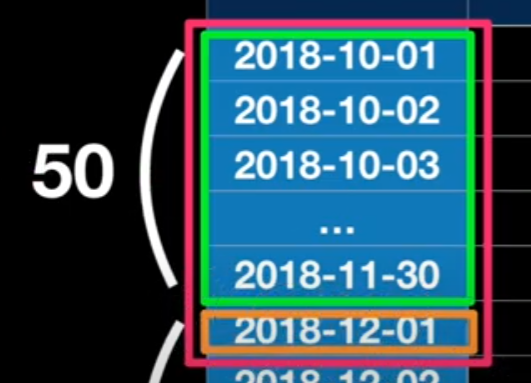

1. 빨간색 범위 51개의 데이터를 저장합니다.
1. 초록색 범위 50개의 데이터를 보고
1. 주황색 범위 1개를 예측합니다.
1. 한칸씩 범위가 밀려나면서 반복합니다.

In [ ]:
seq_len = 50 # 시퀀스 길이 50 
sequence_length = seq_len + 1 #윈도우의 매커니즘 50개의 과거데이터를 보고 1개를 예측 하기 때문에 50 + 1 

result = [] #51개씩 데이터를 result 에 저장합니다.
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

# normalized data
* 정규화를 하는 이유?
  * 데이터를 좀 더 잘 예측하기 위해!

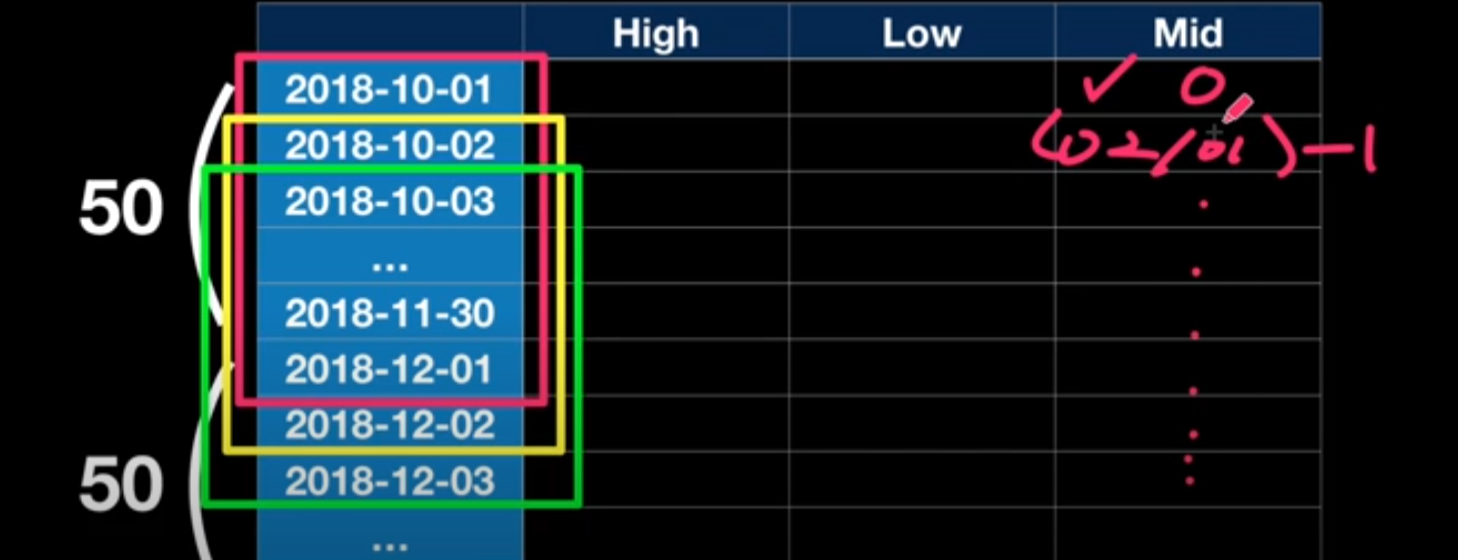

* 첫번째 데이터가 0으로 치는 이유?
  * 자기 자신에서 자기 자신을 빼면 1이고 거기서 -1을 하면 0 이기 때문에 

* (2일데이터 - 1일데이터) - 1 을 내려가면서 반복 해주면 정규화가 된다.

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window] # window를 훑으면서 각 값의 첫번 째 값으로 나눠준 다음에 -1 하면서 정규화 합니다.
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9)) # 트레인세트를 90% 비중으로 나눕니다 
train = result[:row, :]
np.random.shuffle(train) # 스플릿한 트레인 세트를 랜덤으로 셔플해줍니다 

x_train = train[:, :-1] # 50개의 데이터
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1] # 1개의 데이터 

x_test = result[row:, :-1] # 50개의 데이터
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1] # 1개의 데이터 

x_train.shape, x_test.shape

# 1062개의 데이터를 가지고 118일의 데이터를 예측합니다.

((1062, 50, 1), (118, 50, 1))

# build a model

In [ ]:
model = Sequential() # 클래스 선언

model.add(LSTM(50, return_sequences=True, input_shape=(50,1))) # 윈도우 값인 50행 1열 데이터 lstm 유닛수 50개
 
model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear')) # 아웃풋은 다음날 하루의 데이터를 예측하기 때문에 1로 설정 

model.compile(loss='mse', optimizer='rmsprop') # 손실 함수는 mse 사용 

model.summary() # summary 모델 개요를 출력 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# training

In [ ]:
model.fit(x_train,y_train,
          validation_data=(x_test,y_test),
          batch_size=10, # 한번에 몇개씩 묶어서 훈련 시킬 것이냐? / 10개
          epochs=20 # 몇번 반복 할 것이냐? / 20번 
          )

# loss가 낮을 수록 학습이 잘 됩니다! 

Epoch 1/20
107/107 [==============================] - 11s 62ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 2/20
107/107 [==============================] - 5s 50ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/20
107/107 [==============================] - 6s 53ms/step - loss: 0.0012 - val_loss: 5.8449e-04
Epoch 4/20
107/107 [==============================] - 5s 51ms/step - loss: 8.8934e-04 - val_loss: 7.1041e-04
Epoch 5/20
107/107 [==============================] - 6s 52ms/step - loss: 7.3349e-04 - val_loss: 4.6831e-04
Epoch 6/20
107/107 [==============================] - 6s 53ms/step - loss: 6.2465e-04 - val_loss: 5.5174e-04
Epoch 7/20
107/107 [==============================] - 6s 53ms/step - loss: 5.5245e-04 - val_loss: 4.4291e-04
Epoch 8/20
107/107 [==============================] - 8s 74ms/step - loss: 5.2374e-04 - val_loss: 4.8158e-04
Epoch 9/20
107/107 [==============================] - 5s 50ms/step - loss: 4.8975e-04 - val_loss: 4.4181e-04
Epoch 10/20
107/107 [=================

# prediction

4/4 [==============================] - 1s 19ms/step


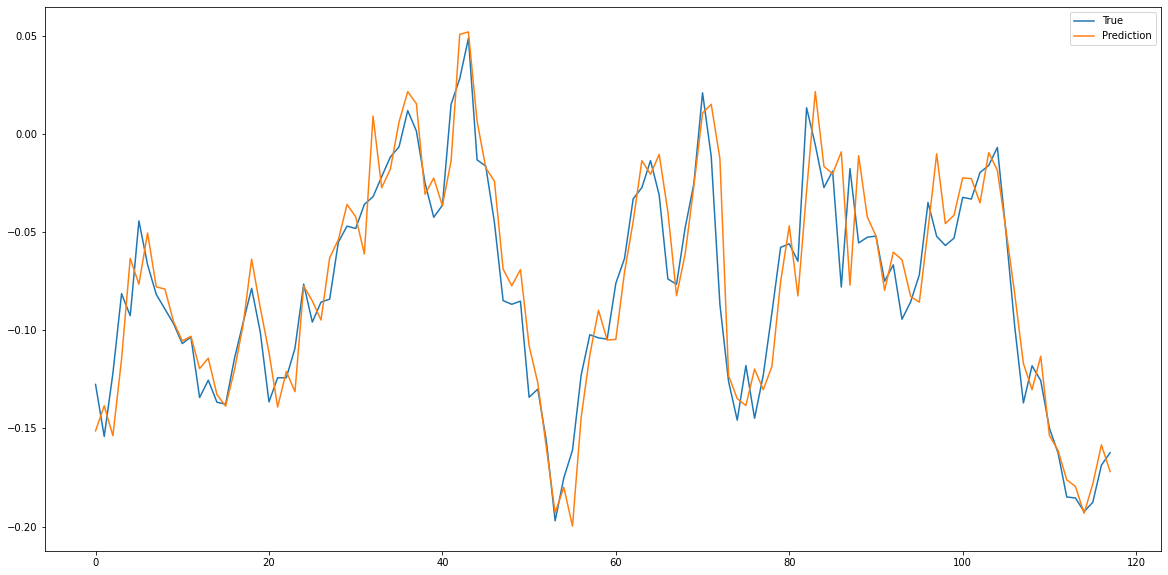

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white',figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()